In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 18})
import re
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, peak_widths
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load Data

In [9]:
def nanotube_properties(n, m, a=0.246):
    """
    Calculate carbon nanotube diameter and chiral angle from arrays n and m.
    
    Parameters
    ----------
    n, m : array-like
        Chiral indices of the carbon nanotubes.
    a : float
        Graphene lattice constant in nanometers (default 0.246 nm).

    Returns
    -------
    diameter : ndarray
        CNT diameters in nanometers.
    angle : ndarray
        Chiral angles in degrees.
    """

    n = np.asarray(n, dtype=float)
    m = np.asarray(m, dtype=float)

    # Diameter formula
    diameter = (a / np.pi) * np.sqrt(n**2 + m**2 + n*m)

    # Chiral angle formula
    angle = np.degrees(np.arctan(np.sqrt(3) * m / (2*n + m)))

    return diameter, angle

In [10]:
path1 = "../Data/Results_Loop_Run/"
if os.path.exists(path1) == True:
    filenames = os.listdir(path1)
    diff_coef_z_list = []
    n_lst = []
    m_lst = []
    Temp_lst = []
    density_lst = []
    water_loc_lst = []
    H_bonds_lst = []
    for i in range(len(filenames)):
        path = path1 + filenames[i] + '/Figures/diffusion_coef_z.csv'
        path2 = path1 + filenames[i] + '/Figures/density_profiles.csv'
        path3 = path1 + filenames[i] +'/Figures/water_locations_end.csv'
        path4 = path1 + filenames[i] +'/Figures/H_Bonds.csv'
        water_locations = pd.read_csv(path3).values
        diff_coef_z = pd.read_csv(path).values[0]
        df_density = pd.read_csv(path2)
        n_bonds = pd.read_csv(path4).values[0]
        diff_coef_z_list.append(diff_coef_z)
        H_bonds_lst.append(n_bonds)
        n = float(filenames[i][5:7])
        m = float(filenames[i][9:11])
        Temp = float(filenames[i][16:])
        n_lst.append(n)
        m_lst.append(m)
        Temp_lst.append(Temp)
        density_lst.append(df_density.values)
        water_loc_lst.append(water_locations)
    n = np.array(n_lst).reshape(-1,1)
    m = np.array(m_lst).reshape(-1,1)
    T = np.array(Temp_lst).reshape(-1,1)
    x_data = np.hstack((n,m,T))
    y_data = np.array(diff_coef_z_list)
    diameter, angle = nanotube_properties(x_data[:,0], x_data[:,1])
    x_data = np.hstack((diameter.reshape(-1,1), angle.reshape(-1,1), T))
else:
    input_data = pd.read_csv('../Data/input_data.csv').values
    x_data = input_data[:,0:3]
    diameter = input_data[:,1]
    angle = input_data[:,2]
    T = input_data[:,3]
    diffusion = input_data[:,3]
    classification = input_data[:,4]
    H_bonds_lst = input_data[:,5]
    y_data = diffusion


## Plot Diffusion 

In [11]:
n_vals = np.linspace(np.min(x_data[:,0]), np.max(x_data[:,0]), 200)
m_vals = np.linspace(np.min(x_data[:,1]), np.max(x_data[:,1]), 200)
N_unscaled, M_unscaled = np.meshgrid(n_vals, m_vals)
scaler = MinMaxScaler()
x_data = scaler.fit(x_data).transform(x_data)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=1
)

In [13]:
# ---------------------------------------------
# Define the regressors you want to compare
# ---------------------------------------------
models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=0),

    # Gaussian Process Regression (with RBF kernel)
    "GaussianProcess": GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * RBF(length_scale=1.0),
        alpha=1e-10,
        normalize_y=True,
        random_state=6
    ),

    "SVR_RBF": SVR(kernel='rbf'),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=0,
        objective='reg:squarederror'
    )
}

# ---------------------------------------------
# Train, predict, and evaluate each model
# ---------------------------------------------
results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train.flatten())
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Save results
    results.append([name, r2, rmse])

# ---------------------------------------------
# Put results into a clean comparison table
# ---------------------------------------------
df_results = pd.DataFrame(results, columns=["Model", "R2", "RMSE"])
df_results = df_results.sort_values(by="R2", ascending=False)

print(df_results)

model = models['RandomForest']
model.fit(X_train, y_train.flatten())

c:\Users\htchi\miniconda3\envs\MSD_simulations\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


             Model        R2      RMSE
0     RandomForest  0.602666  0.000022
1  GaussianProcess -0.042740  0.000035
3          XGBoost -0.044956  0.000035
2          SVR_RBF -5.623799  0.000089


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


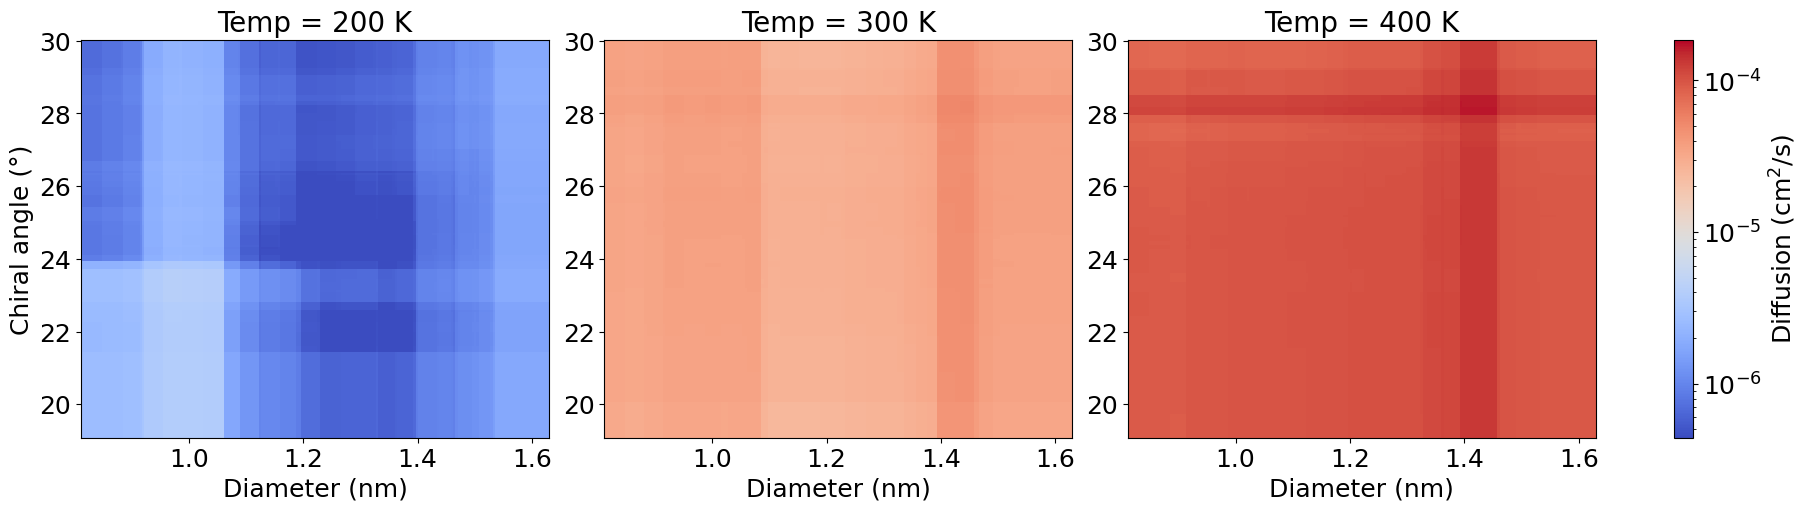

In [14]:
# Choose 3 temperatures to plot
temperatures = [0, 0.5, 1]   # scaled temperatures (0–1)

# Extract ranges from data
diam_min, diam_max = np.min(x_data[:,0][x_data[:,2] > temperatures[0]]), np.max(x_data[:,0][x_data[:,2] > temperatures[0]])
chi_min,  chi_max  = np.min(x_data[:,1][x_data[:,2] > temperatures[0]]), np.max(x_data[:,1][x_data[:,2] > temperatures[0]])

# Create 2D grid in (diameter, chirality)
diam_vals = np.linspace(diam_min, diam_max, 200)
chi_vals  = np.linspace(chi_min,  chi_max,  200)

D, C = np.meshgrid(diam_vals, chi_vals)

# Compute global min/max predictions for color normalization
global_min = np.min(model.predict(x_data[x_data[:,2] > temperatures[0], :]))
global_max = np.max(model.predict(x_data[x_data[:,2] > temperatures[0], :]))
# Make figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, T0 in zip(axes, temperatures):

    # Build model input for entire grid
    grid_points = np.column_stack([
        D.ravel(),
        C.ravel(),
        np.full(D.size, T0)  # fixed temperature
    ])

    # Predict over grid
    preds = model.predict(grid_points).reshape(D.shape)

    # Plot heatmap
    heatmap = ax.pcolormesh(
        D*(np.max(diameter) - np.min(diameter)) + np.min(diameter), C*(np.max(angle) - np.min(angle)) + np.min(angle), preds,
        shading='auto',
        norm=LogNorm(vmin=global_min, vmax=global_max),
        cmap='coolwarm'
    )
    #ax.scatter(diameter, angle)
    # Temperature label (inside plot)
    ax.set_title(f"Temp = {int(T0*200 + 200)} K",
        fontsize=20,
    )

    ax.set_xlabel("Diameter (nm)")
    if T0 == 0:
        ax.set_ylabel("Chiral angle (°)")
    #ax.set_xticks([6,7,8,9,10,11,12])
    #ax.set_xlim(0.85, 1.6)

# Shared colorbar
cbar = fig.colorbar(heatmap, ax=axes.ravel().tolist(), label="Diffusion (cm$^{2}$/s)")
# plt.savefig('../Figures/Diffusion.png', dpi=600, bbox_inches="tight")


C:\Users\htchi\AppData\Local\Temp\ipykernel_26264\2291040715.py:21: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-Ea / (R * T))
C:\Users\htchi\AppData\Local\Temp\ipykernel_26264\2291040715.py:21: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-Ea / (R * T))
C:\Users\htchi\AppData\Local\Temp\ipykernel_26264\2291040715.py:21: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-Ea / (R * T))
C:\Users\htchi\AppData\Local\Temp\ipykernel_26264\2291040715.py:21: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-Ea / (R * T))
C:\Users\htchi\AppData\Local\Temp\ipykernel_26264\2291040715.py:21: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-Ea / (R * T))


   diameter_input  chirality_input  actual_diameter  actual_chirality  \
0             0.0                1         0.813761              30.0   
1             0.2                1         0.976514              30.0   
2             0.6                1         1.302018              30.0   
3             0.8                1         1.464771              30.0   
4             1.0                1         1.627523              30.0   

          A  Ea_J_per_mol        R2  
0  0.002908  11353.110360  0.862047  
1  0.002880  11078.473267  0.837675  
2  0.005130  12841.466384  0.900860  
3  0.002309  10176.120502  0.909873  
4  0.002396  10501.029231  0.910269  


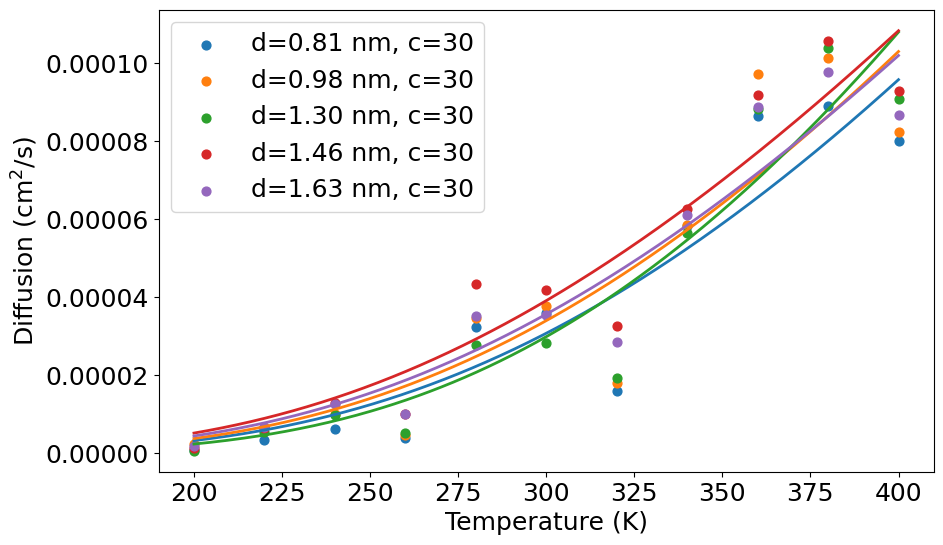

In [15]:
# -----------------------
# User inputs
# -----------------------
diameter_list = [0, 0.2, 0.6, 0.8, 1]        # modify as needed
chirality_list = [1]               # you can also vary chirality
temps = np.array([0, .1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Temperature mapping
actual_temps = temps * 200 + 200   # 200–400 K

# Conversion functions (from your scaling)
def convert_diameter(x):
    return x * (1.6275229 - 0.81376145) + 0.81376145

def convert_chirality(x):
    return x * (30 - 19.10660535) + 19.10660535

# Arrhenius model
R = 8.314
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / (R * T))

# To store fit results
fit_records = []

plt.figure(figsize=(10, 6))

# -------------------------------------------
# Loop over diameters & chiralities
# -------------------------------------------
for d in diameter_list:
    for c in chirality_list:
        
        # Build input matrix for model
        d_arr = np.ones_like(temps) * d
        c_arr = np.ones_like(temps) * c
        
        all_data = np.vstack([
            d_arr,
            c_arr,
            temps
        ]).T
        
        # Predict with your model
        prediction = model.predict(all_data).flatten()
        
        # Fit Arrhenius curve
        popt, pcov = curve_fit(arrhenius, actual_temps, prediction, p0=[1, 50000])
        A_fit, Ea_fit = popt
        
        # Goodness of fit (R²)
        residuals = prediction - arrhenius(actual_temps, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((prediction - np.mean(prediction))**2)
        r2 = 1 - (ss_res / ss_tot)
        
        # Store result
        fit_records.append({
            "diameter_input": d,
            "chirality_input": c,
            "actual_diameter": convert_diameter(d),
            "actual_chirality": convert_chirality(c),
            "A": A_fit,
            "Ea_J_per_mol": Ea_fit,
            "R2": r2
        })
        
        # Generate smooth plot curve
        T_smooth = np.linspace(min(actual_temps), max(actual_temps), 300)
        y_smooth = arrhenius(T_smooth, A_fit, Ea_fit)
        
        # Plot data and fit
        label = f"d={convert_diameter(d):.2f} nm, c={convert_chirality(c):.0f}"
        plt.scatter(actual_temps, prediction, label=f"{label}", s=40)
        plt.plot(T_smooth, y_smooth, linewidth=2)

# Plot styling
plt.xlabel("Temperature (K)")
plt.ylabel("Diffusion (cm$^{2}$/s)")
plt.legend()
# plt.savefig('../Figures/Diffusion_temp.png', dpi=600, bbox_inches="tight")
# -------------------------------------------
# Convert results into DataFrame
# -------------------------------------------
df_fits = pd.DataFrame(fit_records)
print(df_fits)



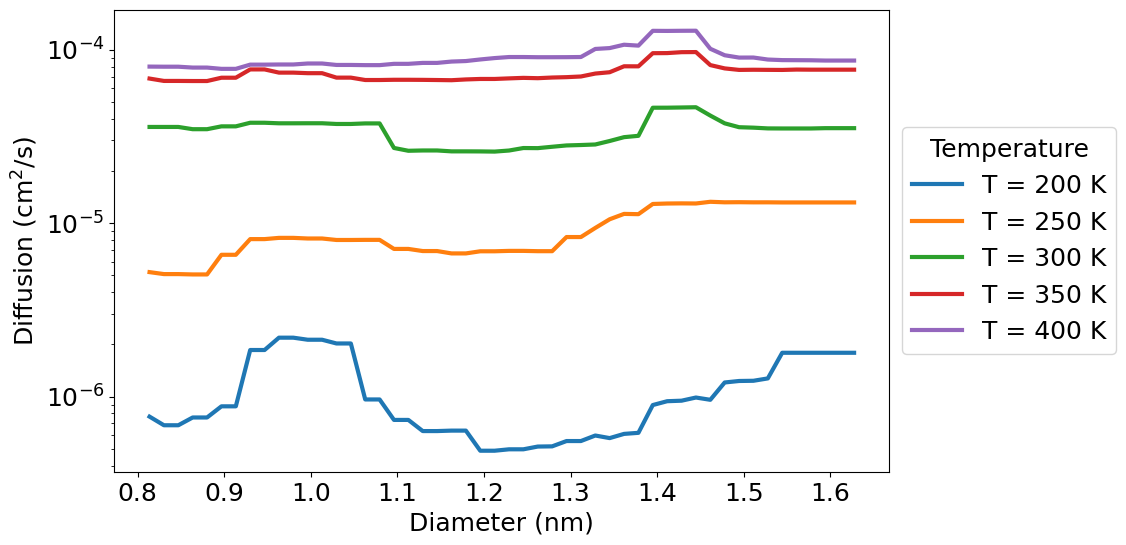

In [16]:
# -----------------------
# User Inputs
# -----------------------
diameter_list = np.linspace(0, 1, 50)   # 0–1 scaled diameter values
chirality = 1                           # fixed chirality (scaled 0–1)
temps = np.array([0, 0.25, 0.5, 0.75, 1.0])

# Convert scaled temperature to Kelvin
actual_temps = temps * 200 + 200        # 200–400 K

# Conversion functions
def convert_diameter(x):
    return x * (1.6275229 - 0.81376145) + 0.81376145

def convert_chirality(x):
    return x * (30 - 19.10660535) + 19.10660535

# Convert chirality once (constant)
actual_chi = convert_chirality(chirality)

# -------------------------------
# Plot: Diameter vs. Diffusion
# -------------------------------
plt.figure(figsize=(10, 6))

for T_scaled, T_actual in zip(temps, actual_temps):

    # Build model inputs for this temperature
    d_arr = diameter_list
    c_arr = np.full_like(d_arr, chirality)
    T_arr = np.full_like(d_arr, T_scaled)

    data_grid = np.vstack([d_arr, c_arr, T_arr]).T

    # Predict
    diffusion = model.predict(data_grid).flatten()

    # Convert diameter values for plotting
    diam_actual = convert_diameter(d_arr)

    # Plot each temperature curve
    plt.plot(diam_actual, diffusion, label=f"T = {T_actual:.0f} K", linewidth=3)

# Plot formatting
plt.xlabel("Diameter (nm)", fontsize=18)
plt.ylabel("Diffusion (cm$^{2}$/s)", fontsize=18)
#plt.title(f"Diffusion vs Diameter at Different Temperatures\nChirality = {actual_chi:.1f}°", fontsize=16)
plt.legend(
    title="Temperature",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.yscale('log')
plt.show()


## Plot Radial Density Profile

In [17]:
from scipy.signal import find_peaks, peak_widths

# Tunable peak detection parameters
peak_height     = 0.05       # minimum peak height
peak_prominence = 0.04       # how much the peak stands out
peak_width      = 2          # minimal width (in data points)
peak_distance   = 15         # minimal spacing between peaks (in data points)

classification = []
for i in range(len(density_lst)): 
#for i in range(10):    
    r_center = density_lst[i][:-30, 0].reshape(-1,1)
    oxy_norm = density_lst[i][:-30, 3]

    # Smooth data
    window = 10
    oxy_smooth = np.convolve(oxy_norm, np.ones(window)/window, mode='same').reshape(-1,1)
    oxy_smooth = np.vstack((np.flip(oxy_smooth), oxy_smooth)).flatten()
    r_center = np.vstack((np.flip(-r_center), r_center)).flatten()

    # ---- Peak Finding ----
    peaks, props = find_peaks(
        oxy_smooth,
        height=peak_height,
        prominence=peak_prominence,
        width=peak_width,
        distance=peak_distance  # <<< NEW
    )

    if len(peaks) == 1:
        classification.append(1)
    elif len(peaks) == 2:
        classification.append(2)
    elif len(peaks) == 3:
        classification.append(3)
    elif len(peaks) == 4:
        classification.append(4)
    # Compute peak widths
    results_half = peak_widths(oxy_smooth, peaks, rel_height=0.5)

    # # # # ---- Plotting ----
    # fig, ax = plt.subplots()

    # # Smoothed signal
    # ax.plot(r_center, oxy_smooth, label="Smoothed Oxy Density")

    # # Plot detected peaks
    # ax.plot(r_center[peaks], oxy_smooth[peaks], "ro", label="Detected Peaks")

    # Plot width indicators
    for idx, p in enumerate(peaks):
        left = r_center[int(results_half[2][idx])]
        right = r_center[int(results_half[3][idx])]
        #height_line = oxy_smooth[p] - results_half[1][idx]
        #ax.hlines(y=height_line, xmin=left, xmax=right, color="r", alpha=0.3)

    ax.set_title(str(filenames[i]) + ' Class: ' + str(len(peaks)))
    ax.set_xlabel("r (distance)")
    ax.set_ylabel("Density")
    ax.legend()

    plt.show()


C:\Users\htchi\AppData\Local\Temp\ipykernel_26264\1308839999.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


In [18]:
n_vals = np.linspace(np.min(x_data[:,0]), np.max(x_data[:,0]), 200)
m_vals = np.linspace(np.min(x_data[:,1]), np.max(x_data[:,1]), 200)
N_unscaled, M_unscaled = np.meshgrid(n_vals, m_vals)

scaler = MinMaxScaler()
x_data = scaler.fit(x_data).transform(x_data)

y_data = np.array(classification) - 1

X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=1
)

In [19]:
# ---------------------------------------------
# Define the classifiers you want to compare
# ---------------------------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=0),

    "GaussianProcess": GaussianProcessClassifier(
        kernel=ConstantKernel(1.0) * RBF(length_scale=1.0),
        random_state=0
    ),

    "SVC_RBF": SVC(kernel="rbf", probability=True, random_state=0),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=0,
        eval_metric="logloss"
    )
}

# ---------------------------------------------
# Train, predict, and evaluate each model
# ---------------------------------------------
results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    # Save results
    results.append([name, accuracy, f1])

# ---------------------------------------------
# Put results into a clean comparison table
# ---------------------------------------------
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
df_results = df_results.sort_values(by="Accuracy", ascending=False)

print(df_results)
model = models['XGBoost']
model.fit(X_train, y_train)

             Model  Accuracy  F1 Score
0     RandomForest  0.894737  0.899580
3          XGBoost  0.894737  0.899580
2          SVC_RBF  0.789474  0.737374
1  GaussianProcess  0.736842  0.770513


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


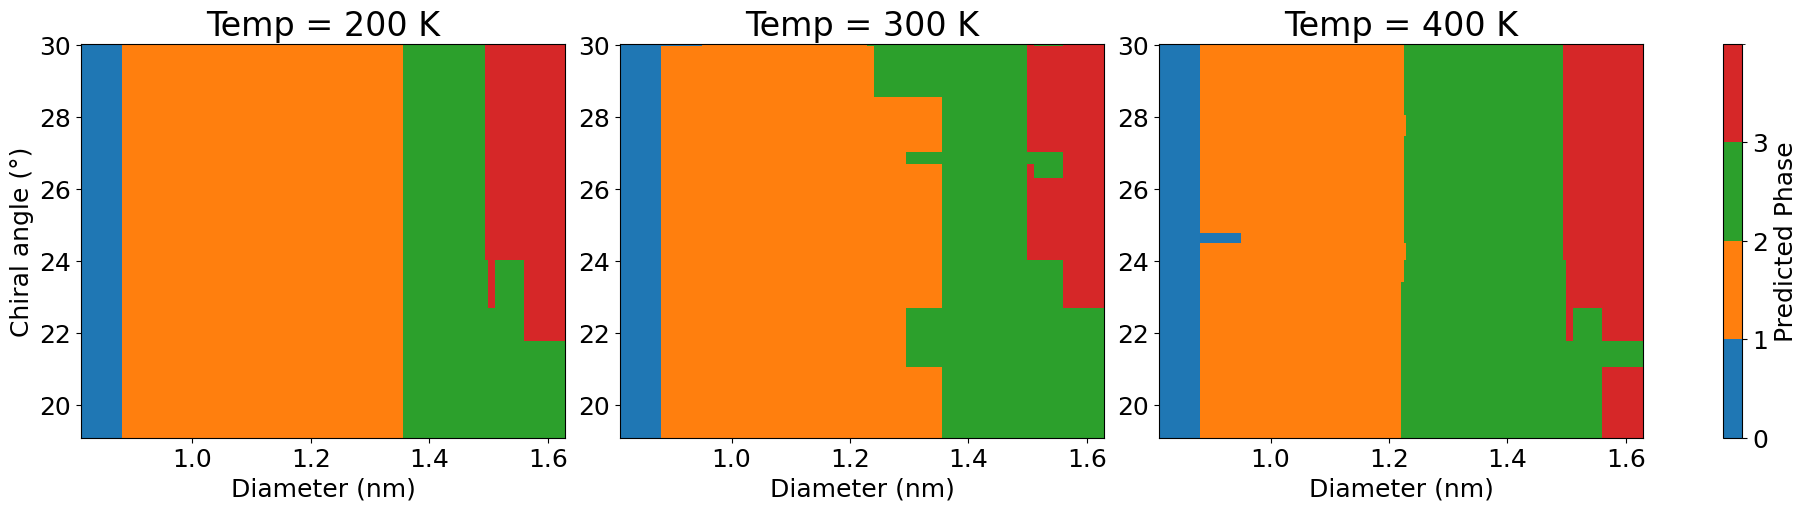

In [20]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# ---- Discrete colormap (unchanged) ----
cmap = ListedColormap(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, cmap.N)

# ---- Select temperatures (scaled 0–1 range) ----
temperatures = [0, 0.5, 1.0]

# ---- Extract diameter & chirality ranges from x_data ----
diam_min, diam_max = np.min(x_data[:,0][x_data[:,2] > temperatures[0]]), np.max(x_data[:,0][x_data[:,2] > temperatures[0]])
chi_min,  chi_max  = np.min(x_data[:,1][x_data[:,2] > temperatures[0]]), np.max(x_data[:,1][x_data[:,2] > temperatures[0]])

# ---- Create grid ----
diam_vals = np.linspace(diam_min, diam_max, 200)
chi_vals  = np.linspace(chi_min,  chi_max,  200)

D, C = np.meshgrid(diam_vals, chi_vals)

# ---- Figure ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, T0 in zip(axes, temperatures):

    # Build full grid for model input
    grid_points = np.column_stack([
        D.ravel(),
        C.ravel(),
        np.full(D.size, T0)
    ])

    # Predict & reshape into grid
    class_pred = model.predict(grid_points).astype(int).reshape(D.shape)

    # Plot classification heatmap
    heatmap = ax.pcolormesh(
        D*(np.max(diameter) - np.min(diameter)) + np.min(diameter), C*(np.max(angle) - np.min(angle)) + np.min(angle), class_pred,
        shading='auto',
        cmap=cmap,
        norm=norm
    )

    # Temperature label (inside plot)
    ax.set_title(f"Temp = {int(T0*200 + 200)} K",
        fontsize=24,
    )
    #ax.scatter(diameter, angle, color='k')
    ax.set_xlabel("Diameter (nm)")
    if T0 == 0:
        ax.set_ylabel("Chiral angle (°)")

# ---- Colorbar (discrete) ----
cbar = fig.colorbar(
    heatmap,
    ax=axes.ravel().tolist(),
    boundaries=bounds,
    ticks=[0, 1, 2, 3]
)
cbar.set_label("Predicted Phase")
cbar.set_ticklabels(["0", "1", "2", "3"])

# plt.savefig('../Figures/Phasemap.png', dpi=600, bbox_inches="tight")


([], [])

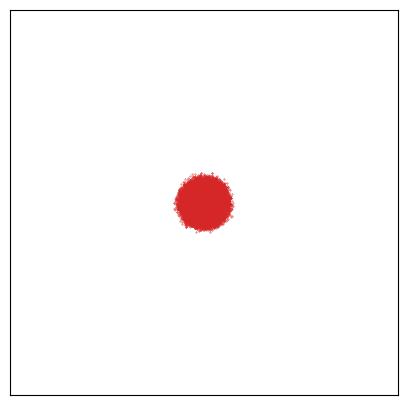

In [21]:
i = 5
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(water_loc_lst[i][:,0], water_loc_lst[i][:,1], s=0.1, color='C3')
plt.xlim([0.5, 2])
plt.ylim([0.5, 2])
plt.yticks([])
plt.xticks([])
#plt.title(str(filenames[i]))
#plt.savefig('../Figures/Phase_4.png', dpi=600, bbox_inches="tight")

## Hydrogen Bonds per Confined Water Molecule

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    x_data, np.array(H_bonds_lst), test_size=0.2, random_state=1
)

In [23]:
input_data = pd.DataFrame(np.array(H_bonds_lst), columns=['Hydrogen_Bonds'])
input_data.to_csv('Hydrogen_Bonds.csv', index=False)

In [24]:
# ---------------------------------------------
# Define the regressors you want to compare
# ---------------------------------------------
models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=0),

    # Gaussian Process Regression (with RBF kernel)
    "GaussianProcess": GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * RBF(length_scale=1.0),
        alpha=1e-10,
        normalize_y=True,
        random_state=6
    ),

    "SVR_RBF": SVR(kernel='rbf'),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=0,
        objective='reg:squarederror'
    )
}

# ---------------------------------------------
# Train, predict, and evaluate each model
# ---------------------------------------------
results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train.flatten())
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Save results
    results.append([name, r2, rmse])

# ---------------------------------------------
# Put results into a clean comparison table
# ---------------------------------------------
df_results = pd.DataFrame(results, columns=["Model", "R2", "RMSE"])
df_results = df_results.sort_values(by="R2", ascending=False)

print(df_results)

model = models['RandomForest']
model.fit(X_train, y_train.flatten())

c:\Users\htchi\miniconda3\envs\MSD_simulations\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


             Model        R2      RMSE
0     RandomForest  0.985058  0.027420
2          SVR_RBF  0.918366  0.064093
3          XGBoost  0.862418  0.083206
1  GaussianProcess -0.001508  0.224491


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


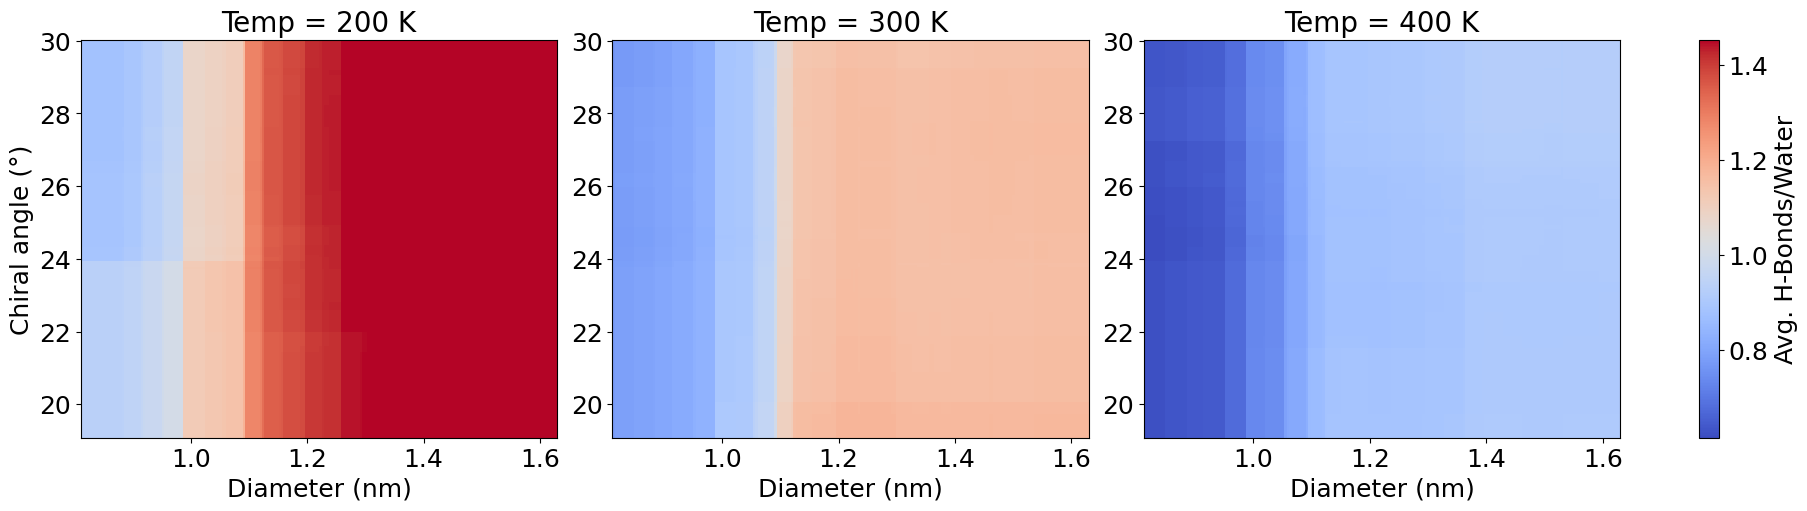

In [25]:
# Choose 3 temperatures to plot
temperatures = [0, 0.5, 1]   # scaled temperatures (0–1)

# Extract ranges from data
diam_min, diam_max = np.min(x_data[:,0][x_data[:,2] > temperatures[0]]), np.max(x_data[:,0][x_data[:,2] > temperatures[0]])
chi_min,  chi_max  = np.min(x_data[:,1][x_data[:,2] > temperatures[0]]), np.max(x_data[:,1][x_data[:,2] > temperatures[0]])

# Create 2D grid in (diameter, chirality)
diam_vals = np.linspace(diam_min, diam_max, 200)
chi_vals  = np.linspace(chi_min,  chi_max,  200)

D, C = np.meshgrid(diam_vals, chi_vals)

# Compute global min/max predictions for colorbar scaling
global_min = np.min(model.predict(x_data[x_data[:,2] > temperatures[0], :]))
global_max = np.max(model.predict(x_data[x_data[:,2] > temperatures[0], :]))

# Make figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for ax, T0 in zip(axes, temperatures):

    # Build model input for entire grid
    grid_points = np.column_stack([
        D.ravel(),
        C.ravel(),
        np.full(D.size, T0)  # fixed temperature
    ])

    # Predict over grid
    preds = model.predict(grid_points).reshape(D.shape)

    # Plot heatmap (NO LOG SCALE)
    heatmap = ax.pcolormesh(
        D*(np.max(diameter) - np.min(diameter)) + np.min(diameter),
        C*(np.max(angle) - np.min(angle)) + np.min(angle),
        preds,
        shading='auto',
        vmin=global_min,
        vmax=global_max,     # linear normalization
        cmap='coolwarm'
    )
    #ax.scatter(diameter, angle, color='k')
    # Temperature label
    ax.set_title(f"Temp = {int(T0*200 + 200)} K", fontsize=20)
    ax.set_xlabel("Diameter (nm)")
    if T0 == 0:
        ax.set_ylabel("Chiral angle (°)")

# Shared colorbar
cbar = fig.colorbar(heatmap, ax=axes.ravel().tolist(), label="Avg. H-Bonds/Water")
# plt.savefig('../Figures/HBonds.png', dpi=600, bbox_inches="tight")



## Show Design Space

In [26]:
n = np.array([6, 7, 8, 9, 10, 11, 12])
n, m = np.meshgrid(n,n)
diameters = np.zeros([len(n),len(n)])
angles = np.zeros([len(n),len(n)])
for i in range(n.shape[0]):
    for j in range(m.shape[1]):
        diameter, angle = nanotube_properties(n[i,j], m[i,j])
        diameters[i,j] = diameter
        angles[i,j] = angle


diameters2, angles2 = nanotube_properties(14,8)
diameters3, angles3 = nanotube_properties(13,9)
diameters4, angles4 = nanotube_properties(9,5)
diameters5, angles5 = nanotube_properties(8,5)
diameters6, angles6 = nanotube_properties(13,8)

Text(0.5, 0, 'Diameter (nm)')

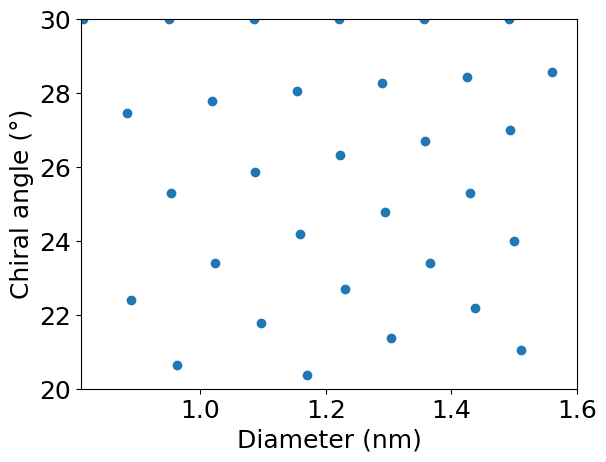

In [27]:
plt.scatter(diameters, angles)
plt.scatter(diameters2, angles2, color='C0')
plt.scatter(diameters3, angles3, color='C0')
plt.scatter(diameters4, angles4, color='C0')
plt.scatter(diameters5, angles5, color='C0')
plt.scatter(diameters6, angles6, color='C0')
plt.xlim([0.81, 1.6])
plt.ylim([20, 30])
plt.ylabel("Chiral angle (°)")
plt.xlabel("Diameter (nm)")
#plt.savefig('../Figures/Sample_Conditions.png', dpi=600, bbox_inches="tight")